In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Input,Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Embedding
from keras import regularizers
from keras.losses import mean_squared_error
import glob
import matplotlib.patches as patches
import json
import numpy as np
from matplotlib.path import Path
import dicom
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/sharonedayan/tensorflow/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


The second step of the algorithm is to train a stacked Auto-encoder in order to get the binary mask of the left ventricule inferred shape within the ROI (region of interest output of CNN). It is performed in two steps : pre-training then fine-tuning.

## Open DataSet

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


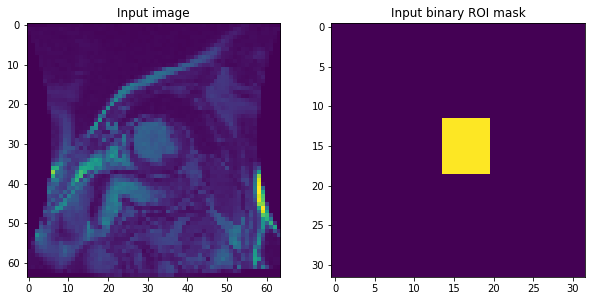

Size for each layer :
Layer, Input Size, Output Size
Conv2D_1 (None, 64, 64, 1) (None, 54, 54, 100)
Average_Pooling2D_1 (None, 54, 54, 100) (None, 9, 9, 100)
Reshape_1 (None, 9, 9, 100) (None, 1, 8100)
Dense_1 (None, 1, 8100) (None, 1, 1024)
Reshape_2 (None, 1, 1024) (None, 1, 32, 32)
Epoch 1/20
495/495 [==============================] - 13s - loss: 0.1798 - acc: 0.2787    
Epoch 2/20
495/495 [==============================] - 11s - loss: 0.1007 - acc: 0.1806    
Epoch 3/20
495/495 [==============================] - 11s - loss: 0.0719 - acc: 0.0448    
Epoch 4/20
495/495 [==============================] - 11s - loss: 0.0560 - acc: 0.0357    
Epoch 5/20
495/495 [==============================] - 11s - loss: 0.0467 - acc: 0.0537    
Epoch 6/20
495/495 [==============================] - 11s - loss: 0.0398 - acc: 0.0584    
Epoch 7/20
495/495 [==============================] - 11s - loss: 0.0359 - acc: 0.0569    
Epoch 8/20
495/495 [==============================] - 11s - loss: 0.0320 - ac

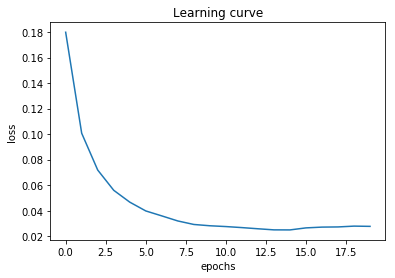

Stored 'y_pred' (ndarray)


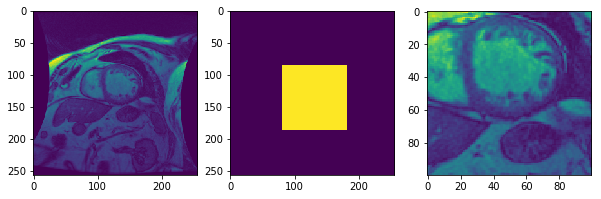

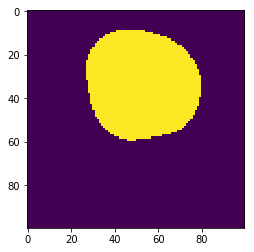

In [2]:
%run 'CNN.ipynb'

In [3]:
%store -r y_pred

In [4]:
input_AE = [] #images (100,100)
for j in range(y_pred.shape[0]):
    input_AE.append(cv2.resize(compute_roi_pred(y_pred, j, roi_shape=32)[0],(64 , 64)))
input_AE = np.asarray(input_AE).reshape((-1, 64*64)) #unrolled : 64*64 = vector of 4096 elements

In [143]:
_,_, mask_contour = compute_roi_pred(y_pred, 234)

contour_experts = [] #images (100,100)
for j in range(y_pred.shape[0]):
    contour_experts.append(cv2.resize(compute_roi_pred(y_pred, j)[2], (64,64), interpolation = cv2.INTERSECT_NONE))
contour_experts = np.asarray(contour_experts).reshape((-1, 64*64)) #unrolled : 64*64 = vector of 4096 elements

In [144]:
#plt.imshow(input_AE[0].reshape(64,64))
#plt.imshow(contour_experts[0].reshape(64,64))

## Stacked auto-encoder : Construction of 3 autoencoder 

In [145]:
from keras import losses
def customized_loss(y_true, y_pred):
    #customize your own loss components
    loss1 = losses.mean_absolute_error(y_true, y_pred)
    loss2 = losses.kullback_leibler_divergence(y_true, y_pred)
    #adjust the weight between loss components
    return 0.0001*0.5 * loss1 + 3 * loss2

In [146]:
X_train = input_AE
Y_train = contour_experts
X_train.shape, Y_train.shape

((495, 4096), (495, 4096))

#### Model 1 : ROI + H1

In [125]:
autoencoder_0 = Sequential()
autoencoder_0.add(Dense(input_dim = 4096, output_dim = 100, kernel_regularizer=regularizers.l2(3*0.001)))
autoencoder_0.add(Dense(input_dim = 100, output_dim = 4096, kernel_regularizer=regularizers.l2(3*0.001)))
autoencoder_0.compile(loss= customized_loss,
              optimizer='adam', metrics=['accuracy'])
autoencoder_0.fit(input_AE, input_AE, epochs=100, verbose=2)

encoder_0 = Dense(input_dim = 4096, output_dim = 100, kernel_regularizer=regularizers.l2(3*0.001))
decoder_0 = Dense(input_dim = 100, output_dim = 4096, kernel_regularizer=regularizers.l2(3*0.001))

temp_0 = Sequential()
temp_0.add(encoder_0)
temp_0.compile(loss= customized_loss,
              optimizer='adam', metrics=['accuracy'])
X_train_1 = temp_0.predict(X_train)

Epoch 1/100
1s - loss: 66475.3537 - acc: 0.0000e+00
Epoch 2/100
0s - loss: 17511.4127 - acc: 0.0000e+00
Epoch 3/100
0s - loss: 13840.9514 - acc: 0.0000e+00
Epoch 4/100
0s - loss: 13287.6216 - acc: 0.0000e+00
Epoch 5/100
0s - loss: 13005.6408 - acc: 0.0000e+00
Epoch 6/100
0s - loss: 12826.6492 - acc: 0.0000e+00
Epoch 7/100
0s - loss: 12679.6496 - acc: 0.0000e+00
Epoch 8/100
0s - loss: 12603.0762 - acc: 0.0000e+00
Epoch 9/100
0s - loss: 12565.9792 - acc: 0.0000e+00
Epoch 10/100
0s - loss: 12525.8129 - acc: 0.0000e+00
Epoch 11/100
0s - loss: 12531.6671 - acc: 0.0000e+00
Epoch 12/100
0s - loss: 12482.5534 - acc: 0.0000e+00
Epoch 13/100
0s - loss: 11513.6298 - acc: 0.0000e+00
Epoch 14/100
0s - loss: 10376.1704 - acc: 0.0000e+00
Epoch 15/100
0s - loss: 9881.8180 - acc: 0.0000e+00
Epoch 16/100
0s - loss: 9667.3246 - acc: 0.0000e+00
Epoch 17/100
0s - loss: 9505.0425 - acc: 0.0000e+00
Epoch 18/100
0s - loss: 9272.0062 - acc: 0.0000e+00
Epoch 19/100
0s - loss: 9196.6287 - acc: 0.0000e+00
Epoch 2

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=4096, units=100, kernel_regularizer=<keras.reg...)`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=4096, kernel_regularizer=<keras.reg...)`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=4096, units=100, kernel_regularizer=<keras.reg...)`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=4096, kernel_regularizer=<keras.reg...)`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=100, kernel_regularizer=<keras.reg...)`


Epoch 1/100
0s - loss: 1083.9213 - acc: 0.0040
Epoch 2/100
0s - loss: 826.2228 - acc: 0.0061
Epoch 3/100
0s - loss: 571.3735 - acc: 0.0162
Epoch 4/100
0s - loss: 415.9060 - acc: 0.0182
Epoch 5/100
0s - loss: 309.1502 - acc: 0.0081
Epoch 6/100
0s - loss: 254.6192 - acc: 0.0000e+00
Epoch 7/100
0s - loss: 198.9047 - acc: 0.0000e+00
Epoch 8/100
0s - loss: 149.8147 - acc: 0.0000e+00
Epoch 9/100
0s - loss: 145.1217 - acc: 0.0000e+00
Epoch 10/100
0s - loss: 136.6178 - acc: 0.0000e+00
Epoch 11/100
0s - loss: 133.8827 - acc: 0.0000e+00
Epoch 12/100
0s - loss: 132.8111 - acc: 0.0000e+00
Epoch 13/100
0s - loss: 131.9349 - acc: 0.0000e+00
Epoch 14/100
0s - loss: 129.1801 - acc: 0.0000e+00
Epoch 15/100
0s - loss: 127.0355 - acc: 0.0000e+00
Epoch 16/100
0s - loss: 124.9785 - acc: 0.0000e+00
Epoch 17/100
0s - loss: 124.5866 - acc: 0.0000e+00
Epoch 18/100
0s - loss: 124.3960 - acc: 0.0000e+00
Epoch 19/100
0s - loss: 124.4888 - acc: 0.0000e+00
Epoch 20/100
0s - loss: 121.0760 - acc: 0.0000e+00
Epoch 21

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=100, kernel_regularizer=<keras.reg...)`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=100, kernel_regularizer=<keras.reg...)`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=100, kernel_regularizer=<keras.reg...)`


In [175]:
for p in autoencoder_0.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_40 (None, 4096) (None, 100)
dense_41 (None, 100) (None, 4096)


#### Model 2 : H1 + H2

In [ ]:
autoencoder_1 = Sequential()
autoencoder_1.add(Dense(input_dim = 100, output_dim = 100, kernel_regularizer=regularizers.l2(3*0.001)))
autoencoder_1.add(Dense(input_dim = 100, output_dim = 100, kernel_regularizer=regularizers.l2(3*0.001)))
autoencoder_1.compile(loss= customized_loss,
              optimizer='adam', metrics=['accuracy'])
autoencoder_1.fit(X_train_1, X_train_1, epochs=100, verbose=2)

encoder_1 = Dense(input_dim = 100, output_dim = 100, kernel_regularizer=regularizers.l2(3*0.001))
decoder_1 = Dense(input_dim = 100, output_dim = 100, kernel_regularizer=regularizers.l2(3*0.001))

In [176]:
for p in autoencoder_1.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_44 (None, 100) (None, 100)
dense_45 (None, 100) (None, 100)


#### Model 3 : H1 + Annotated contours

In [147]:
model = Sequential()
model.add(encoder_0)
model.add(encoder_1)
model.add(Dense(input_dim = 100, output_dim = 4096, init = 'zero', kernel_regularizer=regularizers.l2(3*0.001)))
model.compile(optimizer = 'adam', loss = "MSE", metrics=['accuracy'])

h = model.fit(X_train, Y_train,
          epochs=100, 
          verbose=2)

Epoch 1/100
1s - loss: 27.7172 - acc: 0.0000e+00
Epoch 2/100
0s - loss: 4.2456 - acc: 0.0000e+00
Epoch 3/100
0s - loss: 1.7424 - acc: 0.0020
Epoch 4/100
0s - loss: 1.1157 - acc: 0.0040
Epoch 5/100
0s - loss: 0.8360 - acc: 0.0020
Epoch 6/100
0s - loss: 0.7423 - acc: 0.0000e+00
Epoch 7/100
0s - loss: 0.6744 - acc: 0.0000e+00
Epoch 8/100
0s - loss: 0.6728 - acc: 0.0020
Epoch 9/100
0s - loss: 0.6640 - acc: 0.0000e+00
Epoch 10/100
0s - loss: 0.6477 - acc: 0.0000e+00
Epoch 11/100
0s - loss: 0.6467 - acc: 0.0020
Epoch 12/100
0s - loss: 0.6470 - acc: 0.0000e+00
Epoch 13/100
0s - loss: 0.6308 - acc: 0.0020
Epoch 14/100
0s - loss: 0.6354 - acc: 0.0020
Epoch 15/100
0s - loss: 0.6419 - acc: 0.0020
Epoch 16/100
0s - loss: 0.6433 - acc: 0.0000e+00
Epoch 17/100
0s - loss: 0.6206 - acc: 0.0040
Epoch 18/100
0s - loss: 0.6246 - acc: 0.0000e+00
Epoch 19/100
0s - loss: 0.6067 - acc: 0.0020
Epoch 20/100
0s - loss: 0.5989 - acc: 0.0000e+00
Epoch 21/100
0s - loss: 0.5963 - acc: 0.0000e+00
Epoch 22/100
0s - l

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="zero", units=4096, kernel_regularizer=<keras.reg..., input_dim=100)`


In [177]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_42 (None, 4096) (None, 100)
dense_46 (None, 100) (None, 100)
dense_54 (None, 100) (None, 4096)


Text(0.5,0,'epochs')

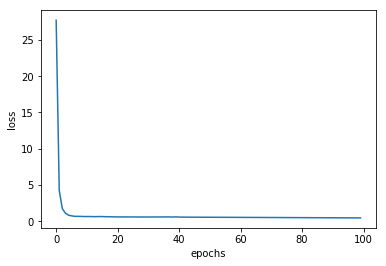

In [148]:
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

#### Prediction

In [150]:
l3_pred = model.predict(X_train)
l3_pred.shape

(495, 4096)

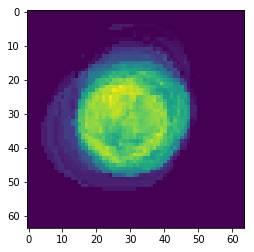

In [166]:
j = 1
# select one predicted ROI
pred3 = l3_pred[j].reshape((64,64))
p = cv2.threshold(pred3, 0, 1, cv2.INTER_AREA)
plt.imshow(p[1])

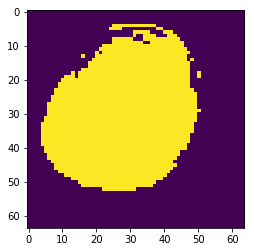

In [174]:
j = 1
# select one predicted ROI
pred3 = l3_pred[j].reshape((64,64))
p = cv2.threshold(pred3, 0, 1, cv2.INTERSECT_NONE)
plt.imshow(p[1])

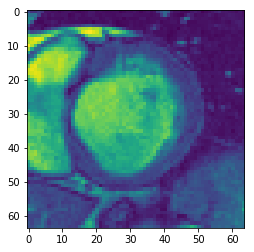

In [162]:
plt.imshow(input_AE[1].reshape(64,64))